In [1]:
import pyproj
import glob
import io
import ipyleaflet
import IPython.display
import ipyvolume.pylab as p3
import json
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pdal
import PIL
import requests
import shapely.geometry
import scipy.spatial
import sys
import urllib.request
import shapely

In [2]:
import subprocess
import json
from shapely.geometry import Polygon

result = subprocess.run(['pdal', 'info', 'C:/Users/prazm/Documents/Python Scripts/data/input/2537_1153.las'],
                        stderr = subprocess.PIPE,  # stderr and stdout get
                        stdout = subprocess.PIPE)  # captured as bytestrings

# decode stdout from bytestring and convert to a dictionary
json_result = json.loads(result.stdout.decode())

In [4]:
print (json_result)

{'file_size': 59893484, 'filename': 'C:/Users/prazm/Documents/Python Scripts/test.laz', 'now': '2022-07-31T11:45:02+0200', 'pdal_version': '2.4.2 (git-version: Release)', 'reader': 'readers.las', 'stats': {'bbox': {'native': {'bbox': {'maxx': 2560957.34, 'maxy': 1145889.72, 'maxz': 1152.7, 'minx': 2560075.67, 'miny': 1145137.73, 'minz': 795.86}, 'boundary': {'type': 'Polygon', 'coordinates': [[[2560075.67, 1145137.73, 795.86], [2560075.67, 1145889.72, 795.86], [2560957.34, 1145889.72, 1152.7], [2560957.34, 1145137.73, 1152.7], [2560075.67, 1145137.73, 795.86]]]}}}, 'statistic': [{'average': 2560567.03, 'count': 10731448, 'maximum': 2560957.34, 'minimum': 2560075.67, 'name': 'X', 'position': 0, 'stddev': 197.4748674, 'variance': 38996.32324}, {'average': 1145498.52, 'count': 10731448, 'maximum': 1145889.72, 'minimum': 1145137.73, 'name': 'Y', 'position': 1, 'stddev': 199.5701792, 'variance': 39828.25643}, {'average': 968.0563265, 'count': 10731448, 'maximum': 1152.7, 'minimum': 795.86, 

In [3]:
coords = json_result['stats']['bbox']['native']['boundary']['coordinates']
bbox_poly = Polygon(*coords)

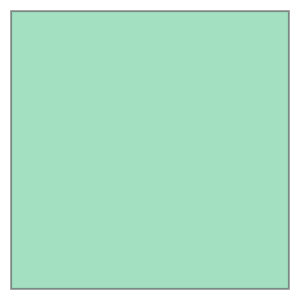

POLYGON Z ((2537000 1153000 470.12, 2537000 1153999.99 470.12, 2537999.99 1153999.99 640.65, 2537999.99 1153000 640.65, 2537000 1153000 470.12))


In [4]:
IPython.display.display(bbox_poly)
print(bbox_poly.wkt)

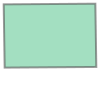

POLYGON Z ((6.617560403585125 46.525323595554624 470.12, 6.6174237407672925 46.53431860652938 470.12, 6.63045787696995 46.53441222164999 640.65, 6.630592373558985 46.525417195225565 640.65, 6.617560403585125 46.525323595554624 470.12))


In [5]:
import pyproj
from shapely.ops import transform
wsg84 = 'epsg:4326'
ch1903plus= 'epsg:2056'
project  = pyproj.Transformer.from_crs(ch1903plus, wsg84, always_xy=True).transform
t_bbox_poly=transform(project, bbox_poly)
IPython.display.display(t_bbox_poly)
print(t_bbox_poly.wkt)

In [6]:
from ipyleaflet import Map, WKTLayer
m = ipyleaflet.Map(center=(46.459222, 6.922641), zoom=15)
wlayer = WKTLayer( wkt_string=t_bbox_poly.wkt,)
m.add_layer(wlayer)
m

Map(center=[46.459222, 6.922641], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

In [7]:
m = ipyleaflet.Map(center=(46.459222, 6.922641), zoom=15)
dc = ipyleaflet.DrawControl()
wlayer = WKTLayer( wkt_string=t_bbox_poly.wkt,)
m.add_layer(wlayer)
m.add_control(dc)
m

Map(center=[46.459222, 6.922641], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

POLYGON ((2537554.722507922 1153638.7271478488, 2537393.6739655645 1153587.040881583, 2537429.9600441675 1153512.8449606653, 2537570.0662664343 1153527.840849228, 2537554.722507922 1153638.7271478488))


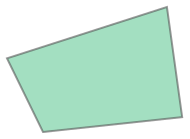

In [8]:
wsg84 = 'epsg:4326'
ch1903plus= 'epsg:2056'
from pyproj import Transformer
transformer = Transformer.from_crs(wsg84, ch1903plus)
coords = [transformer.transform(y,x) for (x,y) in dc.last_draw['geometry']['coordinates'][0]]
polygon = shapely.geometry.Polygon(coords)
print(polygon.wkt)
IPython.display.display(polygon)


In [13]:
lidar_filename = "test.laz"

In [14]:
import pdal
b = polygon.bounds
cropper = {
    "pipeline": [lidar_filename,
        {   "type":"filters.crop",
            'bounds':str(([b[0], b[2]],[b[1], b[3]]))},
        {   "type":"filters.crop",
            'polygon':polygon.wkt},
        #{   "type":"filters.hag"},
        {   "type":"filters.eigenvalues",
            "knn":16},
        {   "type":"filters.normal",
            "knn":16}
    ]}
pipeline = pdal.Pipeline(json.dumps(cropper))
#pipeline.validate()
%time n_points = pipeline.execute()

#print('Pipeline selected {} points ({:.1f} pts/m2)'.format(n_points, n_points/polygon.area))

CPU times: total: 34.9 s
Wall time: 35.5 s


In [15]:
print('Pipeline selected {} points ({:.1f} pts/m2)'.format(n_points, n_points/polygon.area))

Pipeline selected 1199302 points (29.1 pts/m2)


In [16]:
# Load Pipeline output in python objects
arr = pipeline.arrays[0]
description = arr.dtype.descr
cols = [col for col, __ in description]
df = pd.DataFrame({col: arr[col] for col in cols})
df['X_0'] = df['X']
df['Y_0'] = df['Y']
df['Z_0'] = df['Z']
df['X'] = df['X'] - df['X_0'].min()
df['Y'] = df['Y'] - df['Y_0'].min()
df['Z'] = df['Z'] - df['Z_0'].min()

In [17]:
fig = p3.figure(width=600)
fig.xlabel='Y'
fig.ylabel='Z'
fig.zlabel='X'
all_points = p3.scatter(df['Y'], df['Z'], df['X'], color='red', size=.2)
p3.squarelim()
p3.show()

In [18]:
%%javascript
// prevent click on the widget to jump throughout the notebook
$(".jupyter-widgets-view").click(function(e){e.stopPropagation();})

<IPython.core.display.Javascript object>

In [19]:
# Color ground in grey
df['ground'] = df['Classification']==2
ground = p3.scatter(df.loc[df['ground'],'Y'].values, df.loc[df['ground'],'Z'].values, df.loc[df['ground'],'X'].values, color='red', size=.2)
non_ground = p3.scatter(df.loc[~df['ground'],'Y'].values, df.loc[~df['ground'],'Z'].values, df.loc[~df['ground'],'X'].values, color='red', size=.2)
fig.scatters.append(ground)
#fig.scatters.append(non_ground)
all_points.visible = False
ground.color='lightgrey'

In [20]:
# Show ground as surface
ground_delaunay = scipy.spatial.Delaunay(df.loc[df['ground'],['X','Y']])
ground_surf = p3.plot_trisurf(df.loc[df['ground'],'Y'], df.loc[df['ground'],'Z'], df.loc[df['ground'],'X'], ground_delaunay.simplices, color='lightgrey')
fig.meshes.append(ground_surf)
ground.visible=False

In [ ]:
# Show ground as surface
ground_delaunay = scipy.spatial.Delaunay(df.loc[df['ground'],['X','Y']])
ground_surf = p3.plot_trisurf(df.loc[df['ground'],'Y'], df.loc[df['ground'],'Z'], df.loc[df['ground'],'X'], ground_delaunay.simplices, color='lightgrey')
fig.meshes.append(ground_surf)
ground.visible=False

In [ ]:
# Color points according to flatness
df['flatness'] = df['Eigenvalue0'] 
non_ground.color=matplotlib.cm.viridis(df.loc[~df['ground'],'flatness']*4)[:,0:3]

In [ ]:
# Separate between trees and the rest
df['tree_potential'] = df['Classification']==3 
df['other'] = ~df['ground'] & ~df['tree_potential']
tree_potential = p3.scatter(df.loc[df['tree_potential'],'Y'].values, df.loc[df['tree_potential'],'Z'].values, df.loc[df['tree_potential'],'X'].values, color=matplotlib.cm.viridis(df.loc[df['tree_potential'],'flatness']*4)[:,0:3], size=.2)
other = p3.scatter(df.loc[df['other'],'Y'].values, df.loc[df['other'],'Z'].values, df.loc[df['other'],'X'].values, color=matplotlib.cm.viridis(df.loc[df['other'],'flatness']*4)[:,0:3], size=.2)
non_ground.visible=False
tree_potential.color='darkgreen'
other.color='red'

In [ ]:
#Hide non-tree
other.visible=False

In [ ]:
from pcl_utils import local_max

In [ ]:
lep = local_max(df.loc[df['tree_potential'],['X','Y','Z']], radius=3, density_threshold=15)

In [ ]:
treetop_spheres = p3.scatter(lep['Y'].values, lep['Z'].values, lep['X'].values, color='red', size=.5, marker='sphere')
fig.scatters.append(treetop_spheres)

In [ ]:
treetop_spheres.color = matplotlib.cm.tab20(np.arange(len(lep['Z']))%10)[:,0:3]

In [ ]:
kdtree = scipy.spatial.kdtree.KDTree(lep[['X','Y','Z']])
dist, idx = kdtree.query(df.loc[df['tree_potential'],['X','Y','Z']].values)
tree_potential.color=matplotlib.cm.tab20(idx%10)[:,0:3]
df.loc[df['tree_potential'], 'tree_idx'] = idx

In [ ]:
medians = df.groupby('tree_idx')[['X','Y','Z']].median()
for axis in ['X','Y','Z']:
    df['d'+axis] = df[axis] - df['tree_idx'].map(medians[axis])
df['radius'] = np.linalg.norm(df[['dX', 'dY', 'dZ']].values, axis=1)
radii = pd.DataFrame([df.groupby('tree_idx')['radius'].quantile(.5), ]).min()

In [ ]:
scale = max(df['X'].max() - df['X'].min(), df['Y'].max() - df['Y'].min())
treetop_spheres.x = medians['Y']
treetop_spheres.y = medians['Z']
treetop_spheres.z = medians['X']
treetop_spheres.size = radii * 100 / scale

In [ ]:
tree_potential.visible = False

In [ ]:
other.visible = True
treetop_spheres.color='darkgreen'
p3.style.use('minimal')